In [1]:
# --- Importações essenciais ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import patches as mpatches
from scipy.optimize import curve_fit
from astropy.io import fits


In [2]:
# --- Parâmetros iniciais e constantes ---

# Linhas espectrais em repouso (Angstroms)
linhas_bpt = {
    "Ha": 6562.8,
    "Hb": 4861.3,
    "NII": 6583.4,
    "SII_6716": 6716.4,
    "SII_6731": 6730.8,
    "OIII": 5007.0
}

# Parâmetros para integração e ajuste
DELTA = 5           # largura em pixels para integração/ajuste ao redor da linha
DELTA_CONT = 10     # largura para estimar continuum (se usar)
FLUX_MIN = 1e-15    # limite mínimo de fluxo para considerar válido
USAR_GAUSS = True  # se usar ajuste gaussiano para fluxo ou soma simples


In [3]:
# --- Função para carregar cubo FITS e extrair eixo espectral e redshift ---
def carregar_cubo_fits(filename):
    """
    Carrega cubo espectral FITS e extrai eixo espectral e redshift.
    Retorna:
    data, wavelengths, linhas_corrigidas, indices_linhas, ny, nx, z
    """
    with fits.open(filename) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    
    n_waves, ny, nx = data.shape
    crval3 = header['CRVAL3']
    cdelt3 = header['CDELT3']
    crpix3 = header['CRPIX3']
    wavelengths = crval3 + (np.arange(n_waves) + 1 - crpix3) * cdelt3

    z = header.get('REDSHIFT', 0.03)  # padrão se não tiver

    linhas_corrigidas = {nome: wl * (1 + z) for nome, wl in linhas_bpt.items()}
    indices_linhas = {nome: np.abs(wavelengths - wl_obs).argmin() for nome, wl_obs in linhas_corrigidas.items()}

    print(f"Cubo carregado: {n_waves} ondas, {ny}x{nx} pixels")
    print(f"Redshift usado: {z:.5f}")
    print("Linhas corrigidas (Å) e índices:")
    for nome in linhas_bpt:
        print(f" {nome}: {linhas_corrigidas[nome]:.2f} (idx={indices_linhas[nome]})")

    return data, wavelengths, linhas_corrigidas, indices_linhas, ny, nx, z


In [4]:
# --- Função para calcular fluxo simples (integração da linha com subtração de continuum) ---
def fluxo_linha(spectrum, wavelengths, lambda_central, delta=DELTA, delta_cont=DELTA_CONT):
    """
    Calcula fluxo da linha pelo método de integração simples.
    - spectrum: array fluxos no pixel
    - wavelengths: eixo espectral
    - lambda_central: posição da linha (corrigida)
    """
    idx_central = np.abs(wavelengths - lambda_central).argmin()
    idx_min = max(0, idx_central - delta)
    idx_max = min(len(wavelengths)-1, idx_central + delta)

    # Janela da linha e continuum
    linha_fluxo = spectrum[idx_min:idx_max+1]

    # Continuum médio nas janelas laterais
    idx_cont_min1 = max(0, idx_min - delta_cont)
    idx_cont_max1 = idx_min - 1
    idx_cont_min2 = idx_max + 1
    idx_cont_max2 = min(len(wavelengths)-1, idx_max + delta_cont)

    cont1 = spectrum[idx_cont_min1:idx_cont_max1+1] if idx_cont_max1 >= idx_cont_min1 else np.array([])
    cont2 = spectrum[idx_cont_min2:idx_cont_max2+1] if idx_cont_max2 >= idx_cont_min2 else np.array([])

    cont_medio = np.nanmean(np.concatenate([cont1, cont2])) if len(cont1)+len(cont2) > 0 else 0

    flux_liquido = np.nansum(linha_fluxo - cont_medio)

    return flux_liquido


In [5]:
# --- Função gaussiana e ajuste gaussiano para sigma ---
def gaussiana(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + C

def ajuste_gaussiano_por_pixel(spectrum, wavelengths, linha_central, delta=DELTA):
    """
    Ajusta uma gaussiana na linha espectral em um pixel para extrair sigma.
    Retorna sigma em Å.
    """
    idx_central = np.abs(wavelengths - linha_central).argmin()
    idx_min = max(0, idx_central - delta)
    idx_max = min(len(wavelengths) - 1, idx_central + delta)

    x = wavelengths[idx_min:idx_max+1]
    y = spectrum[idx_min:idx_max+1]

    p0 = [np.nanmax(y), linha_central, 1.0, np.nanmin(y)]

    try:
        popt, _ = curve_fit(gaussiana, x, y, p0=p0)
        return abs(popt[2])  # sigma
    except:
        return np.nan


In [6]:
# --- Função para calcular sigma para todas as linhas e pixels ---
def calcular_sigma_linhas(data, wavelengths, linhas_corrigidas, delta=DELTA):
    ny, nx = data.shape[1], data.shape[2]
    sigma_maps = {}
    for linha_nome, linha_central in linhas_corrigidas.items():
        print(f"Calculando sigma para linha {linha_nome}...")
        sigma_map = np.full((ny, nx), np.nan)
        for iy in range(ny):
            for ix in range(nx):
                spectrum = data[:, iy, ix]
                sigma_map[iy, ix] = ajuste_gaussiano_por_pixel(spectrum, wavelengths, linha_central, delta)
        sigma_maps[linha_nome] = sigma_map
    return sigma_maps


In [31]:
# --- Função para plotar mosaico dos mapas sigma ---
def plot_mosaico_sigma(sigma_maps, linhas, filename='mosaico_sigma.png'):
    n_linhas = len(linhas)
    ncols = int(np.ceil(n_linhas / 1))
    nrows = 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for i, linha in enumerate(linhas):
        sigma_map = sigma_maps[linha]
        ax = axes[i]
        vmin, vmax = np.nanpercentile(sigma_map, [5, 95])
        im = ax.imshow(sigma_map, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'Sigma da linha {linha}')
        ax.set_xlabel('Pixel X')
        ax.set_ylabel('Pixel Y')
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Largura sigma (Å)')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    print(f"Mapa sigma salvo: {filename}")
    plt.show()


In [8]:
# --- Função para calcular momentos espectrais ---
def calcular_momentos(data, wavelengths, linha_central, delta=DELTA):
    """
    Calcula momentos 0 (fluxo total), 1 (centroide) e 2 (largura) para cubo espectral.
    Retorna arrays (ny, nx).
    """
    n_waves, ny, nx = data.shape
    momento0 = np.full((ny, nx), np.nan)
    momento1 = np.full((ny, nx), np.nan)
    momento2 = np.full((ny, nx), np.nan)

    idx_central = np.abs(wavelengths - linha_central).argmin()
    idx_min = max(0, idx_central - delta)
    idx_max = min(n_waves - 1, idx_central + delta)

    wave_slice = wavelengths[idx_min:idx_max+1]
    d_lambda = np.gradient(wave_slice)

    for iy in range(ny):
        for ix in range(nx):
            flux = data[idx_min:idx_max+1, iy, ix]
            if np.any(np.isnan(flux)) or np.all(flux <= 0):
                continue
            M0 = np.nansum(flux * d_lambda)
            if M0 <= 0:
                continue
            M1 = np.nansum(wave_slice * flux * d_lambda) / M0
            M2 = np.sqrt(np.nansum((wave_slice - M1)**2 * flux * d_lambda) / M0)

            momento0[iy, ix] = M0
            momento1[iy, ix] = M1
            momento2[iy, ix] = M2

    return momento0, momento1, momento2


In [9]:
# --- Função para plotar momentos ---
def plot_momentos(momento0, momento1, momento2, lambda_0, filename=None):
    """
    Plota os mapas de momento 0 (fluxo total), momento 1 (velocidade radial) e momento 2 (dispersão).
    lambda_0: comprimento de onda de repouso da linha para cálculo da velocidade.
    """
    c = 3e5  # velocidade da luz km/s
    velocidade = c * (momento1 - lambda_0) / lambda_0

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(momento0, origin='lower', cmap='inferno')
    plt.colorbar(label='Momento 0 (Fluxo total)')
    plt.title('Momento 0 (Fluxo total)')

    plt.subplot(1, 3, 2)
    plt.imshow(velocidade, origin='lower', cmap='RdBu_r')
    plt.colorbar(label='Velocidade radial (km/s)')
    plt.title('Momento 1 (Velocidade)')

    plt.subplot(1, 3, 3)
    plt.imshow(momento2, origin='lower', cmap='viridis')
    plt.colorbar(label='Momento 2 (Dispersão Å)')
    plt.title('Momento 2 (Dispersão)')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150)
        print(f"Figura salva: {filename}")
    plt.show()


In [10]:
# --- Função para calcular fluxos usando método escolhido (gauss ou simples) ---
def calcular_fluxos(data, wavelengths, linhas_corrigidas, delta=DELTA, delta_cont=DELTA_CONT, usar_gauss=USAR_GAUSS):
    ny, nx = data.shape[1], data.shape[2]
    flux_maps = {name: np.zeros((ny, nx)) for name in linhas_corrigidas}

    print("Calculando fluxos das linhas...")
    for iy in range(ny):
        for ix in range(nx):
            spectrum = data[:, iy, ix]
            for name, lambda_obs in linhas_corrigidas.items():
                if usar_gauss:
                    # Estima sigma (largura) via gaussiana — se quiser usar pra fluxo pode adaptar
                    # Aqui só usamos o método simples abaixo para fluxo (ainda)
                    flux_maps[name][iy, ix] = fluxo_linha(spectrum, wavelengths, lambda_obs, delta, delta_cont)
                else:
                    flux_maps[name][iy, ix] = fluxo_linha(spectrum, wavelengths, lambda_obs, delta, delta_cont)
    print("Fluxos calculados.")
    return flux_maps


In [11]:
# --- Função para criar máscaras válidas para BPT ---
def gerar_mascaras(flux_maps, flux_min=FLUX_MIN):
    flux_SII = flux_maps["SII_6716"] + flux_maps["SII_6731"]

    mask_valido_n2 = np.logical_and.reduce([
        flux_maps["Ha"] > flux_min,
        flux_maps["Hb"] > flux_min,
        flux_maps["NII"] > flux_min,
        flux_maps["OIII"] > flux_min
    ])

    mask_valido_s2 = np.logical_and.reduce([
        flux_maps["Ha"] > flux_min,
        flux_maps["Hb"] > flux_min,
        flux_SII > flux_min,
        flux_maps["OIII"] > flux_min
    ])
    return mask_valido_n2, mask_valido_s2, flux_SII


In [12]:
# --- Função para calcular razões logarítmicas usadas no BPT ---
def calcular_razões_log(flux_maps, mask_valido_n2, mask_valido_s2, flux_SII):
    log_n2_ha = np.full_like(flux_maps["Ha"], np.nan)
    log_o3_hb_n2 = np.full_like(flux_maps["Ha"], np.nan)
    log_s2_ha = np.full_like(flux_maps["Ha"], np.nan)
    log_o3_hb_s2 = np.full_like(flux_maps["Ha"], np.nan)

    log_n2_ha[mask_valido_n2] = np.log10(flux_maps["NII"][mask_valido_n2] / flux_maps["Ha"][mask_valido_n2])
    log_o3_hb_n2[mask_valido_n2] = np.log10(flux_maps["OIII"][mask_valido_n2] / flux_maps["Hb"][mask_valido_n2])
    log_s2_ha[mask_valido_s2] = np.log10(flux_SII[mask_valido_s2] / flux_maps["Ha"][mask_valido_s2])
    log_o3_hb_s2[mask_valido_s2] = np.log10(flux_maps["OIII"][mask_valido_s2] / flux_maps["Hb"][mask_valido_s2])

    return log_n2_ha, log_o3_hb_n2, log_s2_ha, log_o3_hb_s2


In [13]:
# --- Funções para classificar pixels (N2 e S2) ---
def classify_pixel_n2(log_n2_ha_val, log_o3_hb_val):
    if np.isnan(log_n2_ha_val) or np.isnan(log_o3_hb_val):
        return 0  # Desconhecido
    kewley_line = 0.61 / (log_n2_ha_val - 0.47) + 1.19
    kauffmann_line = 0.61 / (log_n2_ha_val - 0.05) + 1.3
    if log_o3_hb_val > kewley_line:
        return 3  # AGN
    elif log_o3_hb_val > kauffmann_line:
        return 2  # Composto
    else:
        return 1  # Formação Estelar

def classify_pixel_s2(log_s2_ha_val, log_o3_hb_val):
    if np.isnan(log_s2_ha_val) or np.isnan(log_o3_hb_val):
        return 0  # Desconhecido
    kewley_line = 0.72 / (log_s2_ha_val - 0.32) + 1.30
    seyfert_liner_line = 1.89 * log_s2_ha_val + 0.76
    if log_o3_hb_val < kewley_line:
        return 1  # Formação Estelar
    elif log_o3_hb_val > seyfert_liner_line:
        return 2  # Seyfert
    else:
        return 3  # LINER


In [14]:
# --- Função para criar mapa de classificação ---
def classificar_mapa(log_n2_ha, log_o3_hb_n2, log_s2_ha, log_o3_hb_s2, ny, nx):
    classification_map_n2 = np.zeros_like(log_n2_ha, dtype=int)
    classification_map_s2 = np.zeros_like(log_s2_ha, dtype=int)
    for iy in range(ny):
        for ix in range(nx):
            classification_map_n2[iy, ix] = classify_pixel_n2(log_n2_ha[iy, ix], log_o3_hb_n2[iy, ix])
            classification_map_s2[iy, ix] = classify_pixel_s2(log_s2_ha[iy, ix], log_o3_hb_s2[iy, ix])
    return classification_map_n2, classification_map_s2


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

def plot_diagrama_bpt(log_x, log_y, classification_map, mask_valid, labels_classes, colors, xlabel, ylabel, title, filename):
    plt.figure(figsize=(9, 7))
    cmap = ListedColormap(colors)

    valid_x = log_x[mask_valid]
    valid_y = log_y[mask_valid]

    # Se não houver dados válidos, avisa e sai
    if valid_x.size == 0 or valid_y.size == 0 or np.all(np.isnan(valid_x)) or np.all(np.isnan(valid_y)):
        print("Aviso: não há dados válidos para plotagem nesse BPT.")
        plt.close()
        return

    sc = plt.scatter(
        valid_x, valid_y,
        c=classification_map[mask_valid],
        cmap=cmap, s=30, edgecolors='none', alpha=0.8
    )

    x_min_plot = -1.5
    x_max_plot = 1.5

    # Gera array x para as curvas (usando o intervalo fixo que cobre normalmente os dados)
    x = np.linspace(x_min_plot, x_max_plot, 300)

    # Plota as curvas de fronteira conforme o tipo de BPT
    if 'NII' in xlabel:
        # Kewley+01 e Kauffmann+03 para [NII]
        kewley_curve = 0.61 / (x - 0.47) + 1.19
        kauffmann_curve = 0.61 / (x - 0.05) + 1.3
        plt.plot(x, kewley_curve, 'k--', linewidth=2, label='Kewley+06 Limite Estelar')
        plt.plot(x, kauffmann_curve, 'k-.', linewidth=2, label='Kauffmann+03 Limite Empírico')
        plt.xlim(x_min_plot, 0.5)
        plt.ylim(-1.5, 1.5)
    else:
        # Kewley+06 e separação Seyfert/LINER para [SII]
        kewley_curve_s2 = 0.72 / (x - 0.32) + 1.30
        seyfert_liner_line = 1.89 * x + 0.76
        plt.plot(x, kewley_curve_s2, 'k--', linewidth=2, label='Kewley+06 Limite Estelar')
        plt.plot(x, seyfert_liner_line, 'k-', linewidth=2, label='Separação Seyfert/LINER')
        plt.xlim(-1.5, 0.3)
        plt.ylim(-1.5, 1.5)

    # Labels e título (sem negrito)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    # Legenda das classes
    legend_elements = [mpatches.Patch(color=colors[i], label=labels_classes[i]) for i in range(len(labels_classes))]

    # Adiciona legenda das linhas de fronteira
    legend_elements.append(Line2D([0], [0], color='k', lw=2, linestyle='--', label='Kewley+06 Limite Estelar'))
    if 'NII' not in xlabel:
        legend_elements.append(Line2D([0], [0], color='k', lw=2, linestyle='-', label='Separação Seyfert/LINER'))

    plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    print(f"Diagrama salvo: {filename}")
    plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_espectro_medio_profissional(data, wavelengths, linhas_bpt_corrigidas,
                                     filename='espectro_medio_bpt_profissional.png'):
    n_waves, ny, nx = data.shape
    mean_spectrum = np.nanmean(data.reshape(n_waves, ny * nx), axis=1)

    # --- Paleta de cores diferenciada ---
    cores = {
        "Hb": '#1f77b4',        # azul
        "OIII": '#2ca02c',      # verde
        "Ha": '#d62728',        # vermelho
        "NII": '#9467bd',       # roxo
        "SII_6716": '#ff7f0e',  # laranja
        "SII_6731": '#8c564b'   # marrom
    }

    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(wavelengths, mean_spectrum, color='black', linewidth=1.8, label='Espectro Médio')

    # Limites
    ymin, ymax = np.nanmin(mean_spectrum), np.nanmax(mean_spectrum)
    ymargin = 0.12 * (ymax - ymin)
    ax.set_ylim(ymin - 0.05 * (ymax - ymin), ymax + ymargin)

    # Grade suave
    ax.grid(True, linestyle='--', color='gray', alpha=0.4)

    # --- Linhas verticais e handles para legenda ---
    legend_handles = [Line2D([0], [0], color='black', lw=1.8, label='Espectro Médio')]
    for nome, wl in linhas_bpt_corrigidas.items():
        cor = cores.get(nome, 'gray')
        ax.axvline(wl, color=cor, linestyle='--', linewidth=1.2, alpha=0.8)
        legend_handles.append(Line2D([0], [0], color=cor, lw=1.5, linestyle='--', label=nome))

    # --- Legenda dentro do gráfico ---
    ax.legend(handles=legend_handles, fontsize=12, frameon=True,
              loc='lower center', facecolor='white', edgecolor='black')

    # Títulos e rótulos com unidades
    ax.set_title('Espectro Médio do Cubo com Linhas de Emissão', fontsize=16)
    ax.set_xlabel('Comprimento de Onda Observado (Å)', fontsize=14)
    ax.set_ylabel('Fluxo Médio (unidades arbitrárias)', fontsize=14)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"Figura salva: {filename}")
    plt.show()




In [17]:
# --- Função para plotar mosaico dos mapas de fluxo das linhas ---
def plot_mosaico_linhas(cubo_data, indices_linhas, wavelengths, linhas_nomes, filename='mosaico_linhas.png'):
    ny, nx = cubo_data.shape[1], cubo_data.shape[2]
    n_linhas = len(linhas_nomes)

    ncols = int(np.ceil(n_linhas / 2))
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for i, nome_linha in enumerate(linhas_nomes):
        idx = indices_linhas[nome_linha]
        img = cubo_data[idx]

        ax = axes[i]
        vmin, vmax = np.nanpercentile(img, [5, 95])
        im = ax.imshow(img, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
        ax.set_title(f'{nome_linha} λ={wavelengths[idx]:.1f} Å')
        ax.set_xlabel('Pixel X')
        ax.set_ylabel('Pixel Y')

        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Fluxo (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    print(f"Mosaico salvo: {filename}")
    plt.show()


In [18]:
# Caminho do arquivo FITS do cubo espectral
filename = '../ggrNGC1399.fits'

# 1) Carregar cubo, eixo espectral, redshift e linhas corrigidas
data, wavelengths, linhas_corrigidas, indices_linhas, ny, nx, z = carregar_cubo_fits(filename)


Cubo carregado: 6253 ondas, 92x60 pixels
Redshift usado: 0.03000
Linhas corrigidas (Å) e índices:
 Ha: 6759.68 (idx=5471)
 Hb: 5007.14 (idx=1683)
 NII: 6780.90 (idx=5517)
 SII_6716: 6917.89 (idx=5813)
 SII_6731: 6932.72 (idx=5845)
 OIII: 5157.21 (idx=2007)


In [19]:
# 2) Calcular fluxos das linhas por pixel (pode demorar)
flux_maps = calcular_fluxos(data, wavelengths, linhas_corrigidas)


Calculando fluxos das linhas...
Fluxos calculados.


In [20]:
# 3) Gerar máscaras válidas para BPT
mask_valido_n2, mask_valido_s2, flux_SII = gerar_mascaras(flux_maps)


In [21]:
# 4) Calcular as razões logarítmicas
log_n2_ha, log_o3_hb_n2, log_s2_ha, log_o3_hb_s2 = calcular_razões_log(
    flux_maps,
    mask_valido_n2,
    mask_valido_s2,
    flux_SII
)

# 5) Classificar mapa BPT (N2 e S2)
classification_map_n2, classification_map_s2 = classificar_mapa(
    log_n2_ha,
    log_o3_hb_n2,
    log_s2_ha,
    log_o3_hb_s2,
    ny,
    nx
)


In [22]:
# 5) Classificar mapa BPT (N2 e S2)
classification_map_n2, classification_map_s2 = classificar_mapa(log_n2_ha, log_o3_hb_n2, log_s2_ha, log_o3_hb_s2, ny, nx)


Diagrama salvo: diagrama_bpt_n2.png


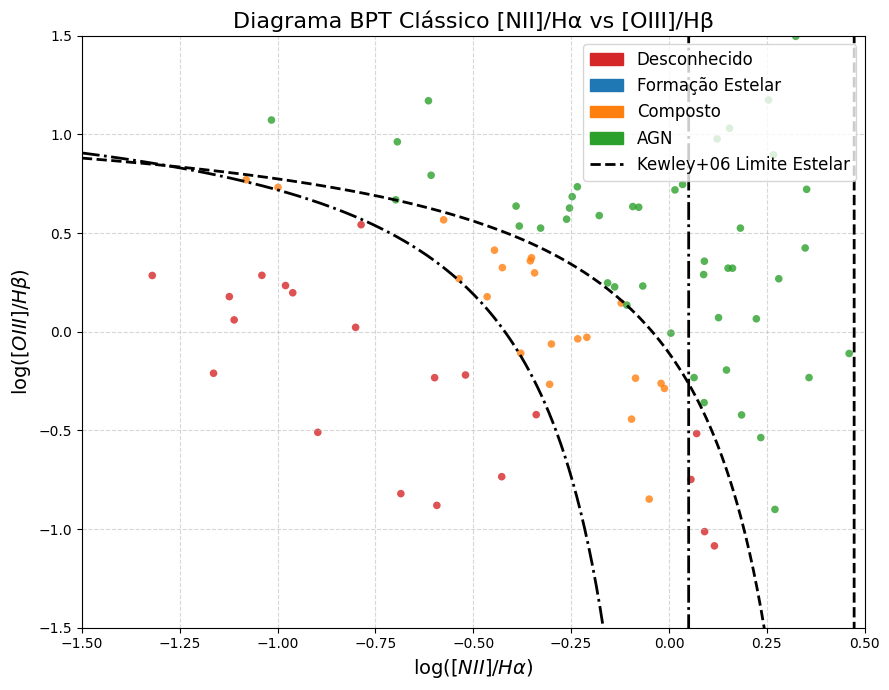

Diagrama salvo: diagrama_bpt_s2.png


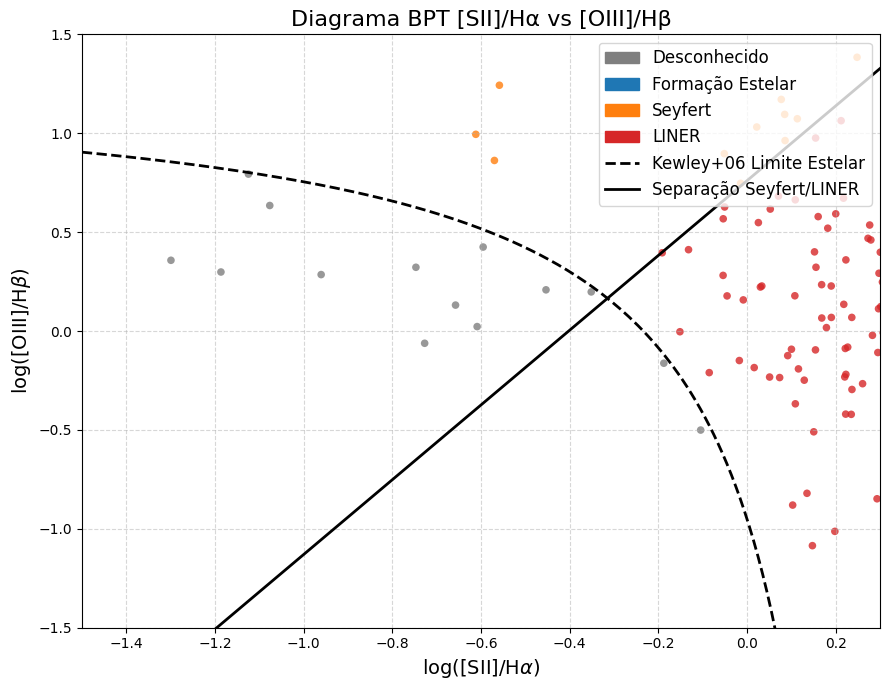

In [23]:
plot_diagrama_bpt(
    log_n2_ha, log_o3_hb_n2, classification_map_n2, mask_valido_n2,
    ['Desconhecido', 'Formação Estelar', 'Composto', 'AGN'],
    ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c'],
    r'$\log([NII]/H\alpha)$',
    r'$\log([OIII]/H\beta)$',
    'Diagrama BPT Clássico [NII]/Hα vs [OIII]/Hβ',
    'diagrama_bpt_n2.png'
)

plot_diagrama_bpt(
    log_s2_ha, log_o3_hb_s2, classification_map_s2, mask_valido_s2,
    ['Desconhecido', 'Formação Estelar', 'Seyfert', 'LINER'],
    ['#7f7f7f', '#1f77b4', '#ff7f0e', '#d62728'],
    r'$\log([\mathrm{SII}]/\mathrm{H}\alpha)$',
    r'$\log([\mathrm{OIII}]/\mathrm{H}\beta)$',
    'Diagrama BPT [SII]/Hα vs [OIII]/Hβ',
    'diagrama_bpt_s2.png'
)


Figura salva: espectro_medio_bpt_profissional.png


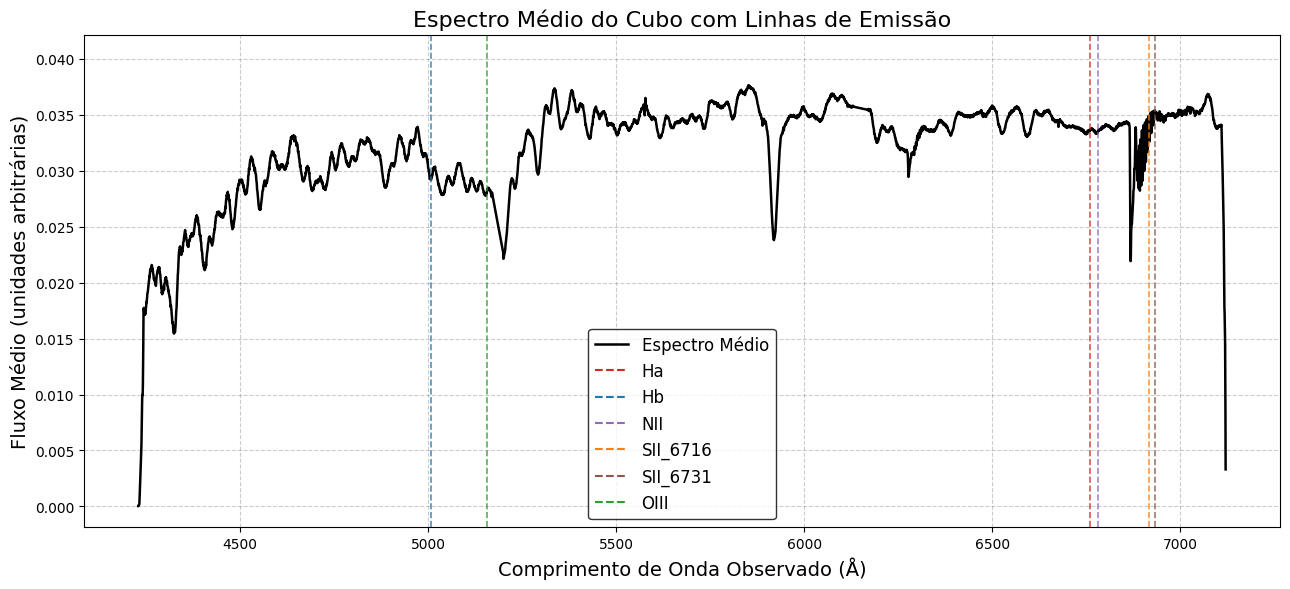

In [24]:
# Uso
plot_espectro_medio_profissional(data, wavelengths, linhas_corrigidas)

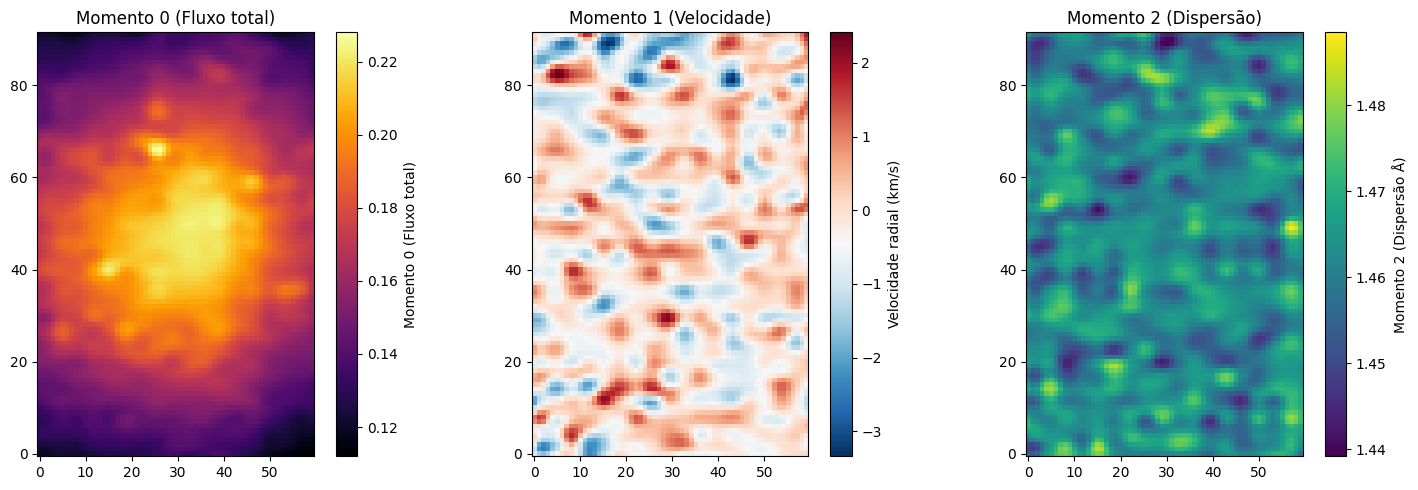

In [25]:
# 8) Calcular momentos para uma linha (exemplo: Hα) e plotar
mom0, mom1, mom2 = calcular_momentos(data, wavelengths, linhas_corrigidas['Ha'])
plot_momentos(mom0, mom1, mom2, linhas_corrigidas['Ha'])


In [26]:
# 9) Calcular mapa sigma (largura) via ajuste gaussiano para as linhas (pode demorar bastante!)
sigma_maps = calcular_sigma_linhas(data, wavelengths, linhas_corrigidas)


Calculando sigma para linha Ha...


/home/meteoro/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Calculando sigma para linha Hb...
Calculando sigma para linha NII...
Calculando sigma para linha SII_6716...
Calculando sigma para linha SII_6731...
Calculando sigma para linha OIII...


Mapa sigma salvo: mosaico_sigma.png


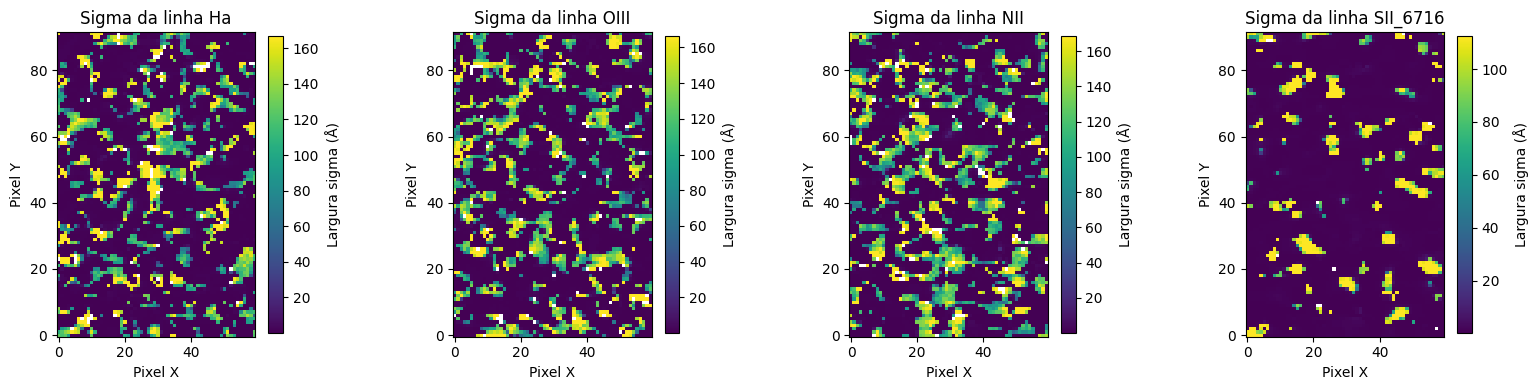

In [32]:
# 10) Plotar mosaico dos mapas sigma para algumas linhas
linhas_para_plot = ['Ha', 'OIII', 'NII', 'SII_6716']
plot_mosaico_sigma(sigma_maps, linhas_para_plot)


Mosaico salvo: mosaico_linhas.png


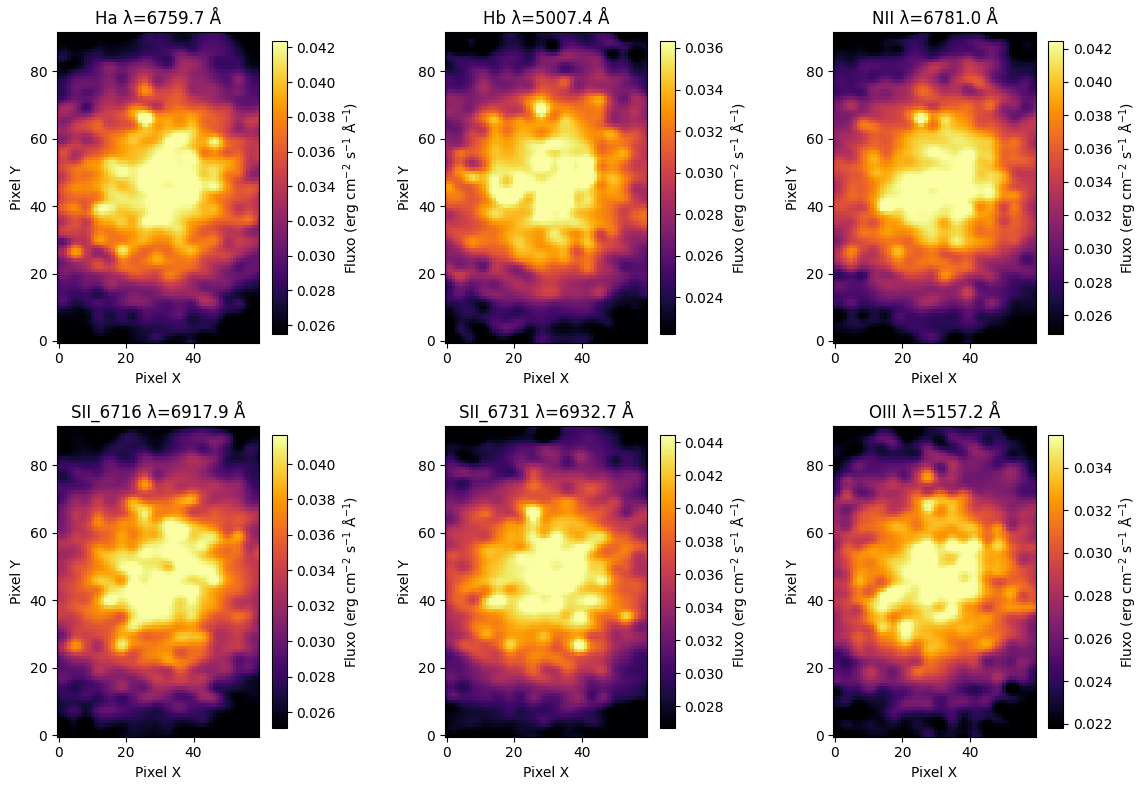

In [28]:
# 11) Plotar mosaico dos mapas de fluxo (pode usar as linhas corrigidas e índices)
nomes_linhas_ordenados = list(linhas_corrigidas.keys())
plot_mosaico_linhas(data, indices_linhas, wavelengths, nomes_linhas_ordenados)
